In [20]:
from google.colab import drive
drive.mount('/mnist')

Drive already mounted at /mnist; to attempt to forcibly remount, call drive.mount("/mnist", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn

## Set random seed for reproducibility
random_seed = 1
torch.manual_seed(random_seed)

In [2]:
mnist_data = datasets.MNIST(
    './data', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/home/nahuel/anaconda3/envs/redes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629434582/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [10]:
def display_digit(digit):
    plt.imshow(digit[0].numpy().squeeze(), cmap='gray')

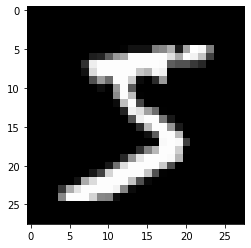

In [11]:
display_digit(mnist_data[0])

In [12]:
mnist_test = datasets.MNIST(
    './data', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

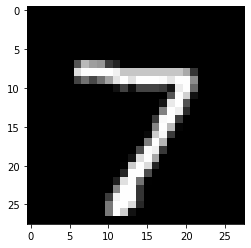

In [13]:
display_digit(mnist_test[0])

In [46]:
mnist_data.data.size()[0]

60000

In [54]:
train_data_len = mnist_data.data.size()[0]
test_data_len  = mnist_test.data.size()[0]

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

n_batch_train = train_data_len // (batch_size_train*log_interval)
n_batch_test = test_data_len // (batch_size_test*log_interval)
n_batch_train

93

In [15]:
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_train, shuffle=True)
test_loader  = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size_test)

In [21]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [22]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.linear1 = nn.Linear(784, 100)
        self.linear2 = nn.Linear(100, 20)
        self.linear3 = nn.Linear(20,10)
        self.relu = nn.ReLU()
        self.flatten = Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [24]:
network = net()
optimizer = torch.optim.SGD(
    network.parameters(), 
    lr=learning_rate,
    momentum=momentum
)

In [85]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [86]:
def train(epoch):
    network.train()
    crossent = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = crossent(output, target)
        loss.backward()
        optimizer.step()
        avg_batch_loss = loss.item() / len(data)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} - Batch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx,
                batch_idx*len(data), 
                len(train_loader.dataset),
                100.*batch_idx / len(train_loader), 
                #loss.item()
                avg_batch_loss
            ))
        #train_losses.append(loss.item())
        train_losses.append(avg_batch_loss)
        train_counter.append(
            (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset))
        )

In [93]:
def test():
    crossent = nn.CrossEntropyLoss()
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            loss = crossent(output, target).item()
            test_loss += loss
            avg_batch_loss = loss / len(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            #test_loss /= len(test_loader.dataset)
            test_losses.append(avg_batch_loss)
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss/len(test_loader.dataset), correct, len(test_loader.dataset),
        100.*correct / len(test_loader.dataset))) ## TODO: Por que 100. y no 100?

In [96]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

test()
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()


Test set: Avg. loss: 0.000082, Accuracy: 9762/10000 (98%)

Train Epoch: 1 - Batch 0 [0/60000 (0%)]	Loss: 0.000078
Train Epoch: 1 - Batch 10 [640/60000 (1%)]	Loss: 0.000272
Train Epoch: 1 - Batch 20 [1280/60000 (2%)]	Loss: 0.000522
Train Epoch: 1 - Batch 30 [1920/60000 (3%)]	Loss: 0.000175
Train Epoch: 1 - Batch 40 [2560/60000 (4%)]	Loss: 0.000231
Train Epoch: 1 - Batch 50 [3200/60000 (5%)]	Loss: 0.000632
Train Epoch: 1 - Batch 60 [3840/60000 (6%)]	Loss: 0.000478
Train Epoch: 1 - Batch 70 [4480/60000 (7%)]	Loss: 0.000093
Train Epoch: 1 - Batch 80 [5120/60000 (9%)]	Loss: 0.000381
Train Epoch: 1 - Batch 90 [5760/60000 (10%)]	Loss: 0.000836
Train Epoch: 1 - Batch 100 [6400/60000 (11%)]	Loss: 0.000153
Train Epoch: 1 - Batch 110 [7040/60000 (12%)]	Loss: 0.000215
Train Epoch: 1 - Batch 120 [7680/60000 (13%)]	Loss: 0.000294
Train Epoch: 1 - Batch 130 [8320/60000 (14%)]	Loss: 0.000135
Train Epoch: 1 - Batch 140 [8960/60000 (15%)]	Loss: 0.000408
Train Epoch: 1 - Batch 150 [9600/60000 (16%)]	Los

In [89]:
network.eval()

net(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten()
)

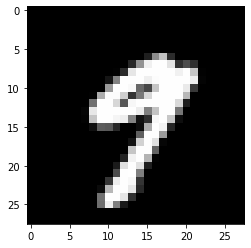

In [29]:
display_digit(mnist_test[20])

In [30]:
network(mnist_test[20][0].unsqueeze(0)).argmax()

tensor(9)

ValueError: cannot reshape array of size 44 into shape (14,3)

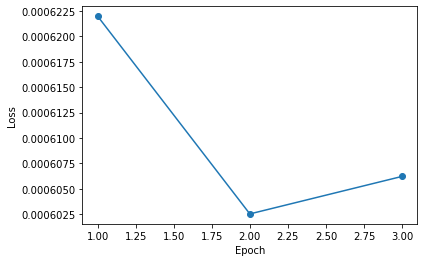

In [95]:
ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 4*nrows), ncols=ncols, nrows=nrows)

ax = axes
labels = ['Train', 'Test']
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

#_train_loss = np.array(train_losses).reshape((len(train_losses)//(n_epochs, n_epochs)).mean(axis=0)
#_test_loss  = np.array(test_losses).
                                             
#for losses in [train_losses, test_losses]:
#for i, losses in enumerate([np.array(train_losses)/batch_size_train, test_losses]):
for i, losses in enumerate([train_losses, test_losses]):

    X = range(1, n_epochs+1)
    Y = np.array(losses).reshape((len(losses)//n_epochs, n_epochs)).mean(axis=0)

    ax.plot(X, Y, 'o-', label=labels[i])
    
ax.legend()
plt.show()

In [84]:
len(test_losses)

17

In [56]:
len(train_losses)

564

In [57]:
len(train_losses)//n_epochs* n_epochs

564